# ✅ features.csv파일 만들기

**🔥모델에 실제 넣을 데이터를 만드는 곳**
<br/><br/>
모델링 작업을 하기 전, 각자의 데이터를 합쳐놓은 데이터프레임 Combined_df 에서 
진짜 모델링을 위해 필요한, 모델링에 사용될 Feature 데이터들을 뽑아내는 과정을 담은 파일입니다. (뽑은 후 features.csv파일 생성)
<br/><br/>

1. **Data Augmentation**

  "원본 original 음성 data"에서 "noise해서 얻은 data",  "stretch 및 pitch를 해서 얻은 data" 를 새로 생성해 **Data Augmentation을 진행**했다. <br/>
즉, 데이터는 (원본 데이터, noise해서 얻은 데이터,  stretch 및 pitch를 해서 얻은 데이터)로 3배 늘어난다.

2. **Feature Extraction**

  1번 Data Augmentation을 거친 후, 모든 데이터들에 대해 **( ZCR, Chroma_stft, MFCC, RMS, MelSpectogram)의 feature를 추출**해낸다.
<br/>

=> 데이터에서 추출된 feature(입력데이터)와 이에 해당하는 감정(정답데이터)을 **features.csv**파일로 생성한다.


---



**[목차 설명]**

1. Data Augmentation <br/>
  : 원본데이터에 -> noise, stretching, shifting, pitching을 각각 적용했을 때 음성파일이 어떻게 바뀌는지 시각화 했다.
2. Feature Extraction <br/>
   : 음성데이터에서 ZCR, Chroma_stft, MFCC, RMS, MelSpectogram 의 특징을 데이터 수치로 추출해 낸다.
  



---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### .0.준비과정

#### ◼Data Load


##### 나현

In [ ]:
# 나현
!unzip /content/drive/MyDrive/AI-CT/Ravdess.zip
!unzip /content/drive/MyDrive/AI-CT/CremaD.zip
!unzip /content/drive/MyDrive/AI-CT/Savee.zip
!unzip /content/drive/MyDrive/AI-CT/Tess.zip

Archive:  /content/drive/MyDrive/AI-CT/Ravdess.zip
replace Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/MyDrive/AI-CT/CremaD.zip
replace AudioWAV/1001_DFA_ANG_XX.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/MyDrive/AI-CT/Savee.zip
replace AudioData/DC/a01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/MyDrive/AI-CT/Tess.zip
replace TESS Toronto emotional speech set data/OAF_Fear/OAF_back_fear.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


##### 은정

In [ ]:
!unzip /content/drive/MyDrive/AI-CT/KEMDy20

Archive:  /content/drive/MyDrive/AI-CT/KEMDy20.zip
replace KEMDy20/.ipynb_checkpoints/concating_data-checkpoint.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

##### 수빈

In [ ]:
!unzip /content/drive/MyDrive/AI-CT/data.zip

Archive:  /content/drive/MyDrive/AI-CT/data.zip
replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

##### Combined_df.csv 파일

In [ ]:
datacsv = "/content/drive/MyDrive/AI-CT/Combined_df.csv"
Combined_df = pd.read_csv(datacsv)

#### ◼import library

In [ ]:
import pandas as pd
import numpy as np
import os
import sys

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
import pylab

import matplotlib.pyplot as plt
import math

## 🔨Data Augmentation


**- Data Augmentation**


> Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.


- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...


First, let's check which augmentation techniques works better for our dataset.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(Combined_df.Path)[1]
data, sample_rate = librosa.load(path)

#### 원본 -> noise, stretching, shifting, pitch 각각 적용 시 
어떤 음성파일이 되는지 시각화 한 것

1. Simple Audio

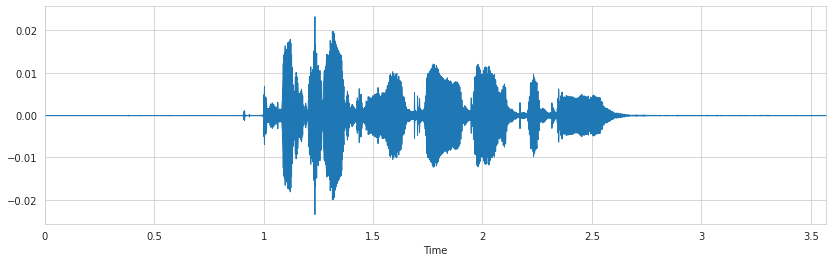

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

2. Noise Injection

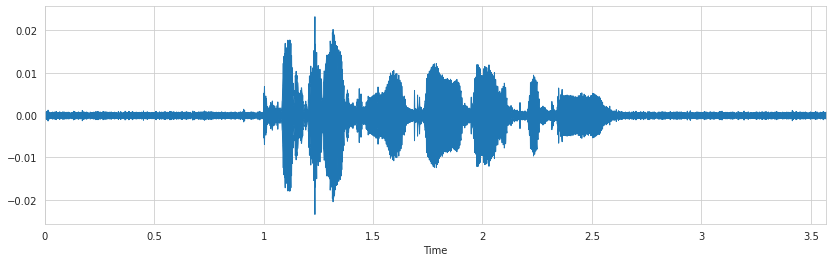

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

3. Stretching

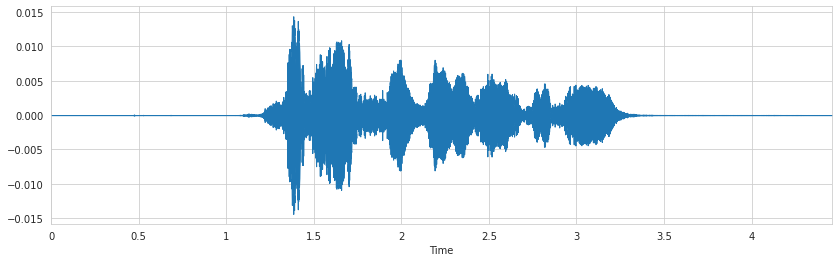

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

4. Shifting

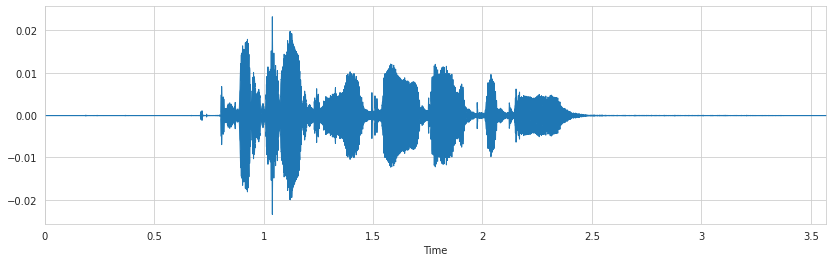

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

5. Pitch

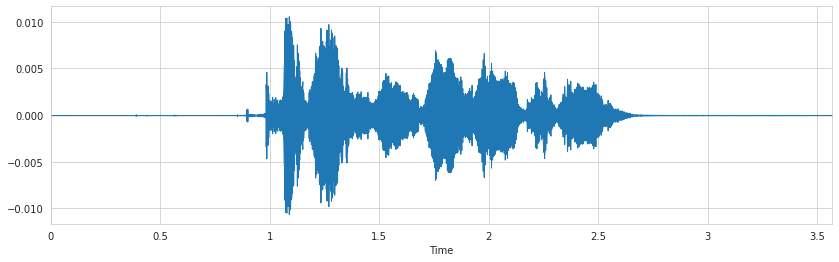

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## 🔨Feature Extraction

- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.
- The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.
-(image)


I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by Askash Mallik on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. bEnergy : The sum of squares of the signal values, normalized by the respective frame length.
3. bEntropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. bSpectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.
In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:

- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(Combined_df.Path, Combined_df.Emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), Combined_df.Path.shape

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()